In [747]:
%pip install numpy pandas tensorflow matplotlib scikit-learn keras statsmodels keras_tuner optuna

Note: you may need to restart the kernel to use updated packages.


In [748]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import r2_score

In [749]:
# Cargar los datos
data = pd.read_csv('datos_limpios0.csv')
data.shape

(1161, 15)

**Factores:**
- **Date**: Date in MM-DD-YYYY
- **Quarter**: A portion of the month. A month was divided into four quarters
- **Department**: Associated department with the instance
- **Day**: Day of the Week
- **Team**: Associated team number with the instance
- **Targeted productivity**: Targeted productivity set by the Authority for each team for each day.
- **SMV**: Standard Minute Value, it is the allocated time for a task
- **WIP**: Work in progress. Includes the number of unfinished items for products
- **Over time**: Represents the amount of overtime by each team in minutes
- **Incentive**: Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
- **Idle time**: The amount of time when the production was interrupted due to several reasons
- **Idle men**: The number of workers who were idle due to production interruption
- **No of style change**: Number of changes in the style of a particular product
- **No of workers**: Number of workers in each team

**Variable de respuesta:**
- **Actual productivity**: The actual % of productivity that was delivered by the workers. It ranges from 0-1.



In [750]:
# Convertir la columna 'Date' a tipo datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Extraer día, mes y año de la columna 'Date'
data['Day'] = data['date'].dt.day
data['Month'] = data['date'].dt.month
data['Year'] = data['date'].dt.year

# Eliminar la columna 'Date'
data.drop(columns=['date'], inplace=True)

# Mostrar las primeras filas del DataFrame
data.head()

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Day,Month,Year
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1,1,2015
1,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500,1,1,2015
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1,2015
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1,2015
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1,1,2015


In [751]:
# Realizo una copia del DataFrame original
data_encoded = data.copy()

# Codificar las columnas categóricas en la copia
data_encoded['quarter'] = data_encoded['quarter'].astype('category').cat.codes
data_encoded['department'] = data_encoded['department'].astype('category').cat.codes
data_encoded['day'] = data_encoded['day'].astype('category').cat.codes
data_encoded['team'] = data_encoded['team'].astype('category').cat.codes

In [752]:
data_encoded.columns.tolist()

['quarter',
 'department',
 'day',
 'team',
 'targeted_productivity',
 'smv',
 'wip',
 'over_time',
 'incentive',
 'idle_time',
 'idle_men',
 'no_of_style_change',
 'no_of_workers',
 'actual_productivity',
 'Day',
 'Month',
 'Year']

In [753]:
features = ['quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']

X = data_encoded[features]

X = pd.get_dummies(X, columns=['day', 'team', 'quarter', 'department'], dtype=int, drop_first=True)
X.head()


,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,day_1,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
0,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0,...,1,0,0,0,0,0,0,0,0,1
1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0,...,0,0,0,1,0,0,0,0,0,1
3,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0,...,0,0,0,0,1,0,0,0,0,1
4,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0,...,0,0,0,0,0,0,0,0,0,1


In [754]:
features_Y = ['quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']

X_more = data_encoded[features_Y]
X_more = pd.get_dummies(X_more, columns=['day', 'team', 'quarter', 'department'], dtype=int, drop_first=True)


In [755]:
X_more.shape

(1161, 31)

In [756]:
Y = data_encoded["actual_productivity"]

Y.head()

0    0.940725
1    0.886500
2    0.800570
3    0.800570
4    0.800382
Name: actual_productivity, dtype: float64

In [757]:
train = X_more.sample(frac=0.8, random_state=100)
train.head()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
892,0.8,15.26,1053.0,4080,50,0.0,0,0,34.0,0.800402,...,0,0,0,0,1,0,0,1,0,1
492,0.8,4.30,0.0,1200,0,0.0,0,0,10.0,0.989000,...,0,0,0,0,0,0,0,0,1,0
137,0.8,19.87,857.0,9900,50,0.0,0,0,55.0,0.800274,...,0,0,0,0,0,1,0,0,0,1
638,0.8,3.94,0.0,1200,0,0.0,0,0,10.0,0.893067,...,0,0,0,0,0,1,0,0,0,0
918,0.7,30.33,398.0,6960,0,0.0,0,1,58.0,0.662379,...,0,0,0,0,0,0,0,1,0,1


In [758]:
test = X_more.drop(train.index)
test.head()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
2,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,...,0,0,0,1,0,0,0,0,0,1
11,0.75,19.31,578.0,6480,45,0.0,0,0,54.0,0.712205,...,0,0,1,0,0,0,0,0,0,1
13,0.65,3.94,0.0,960,0,0.0,0,0,8.0,0.705917,...,0,0,1,0,0,0,0,0,0,0
17,0.65,23.69,861.0,7200,0,0.0,0,0,60.0,0.521180,...,0,0,0,0,0,0,0,0,0,1
34,0.75,19.87,944.0,6600,45,0.0,0,0,55.0,0.750243,...,0,0,0,0,0,0,0,0,0,1


In [759]:
print(train.shape)
print(test.shape)

(929, 31)
(232, 31)


Realicemos una exploración descriptiva de los datos, calculando inicialmente estadísticas de cada variable continua

In [760]:
train.describe()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,...,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,0.727417,15.149343,672.769645,4623.907427,39.216362,0.919806,0.368138,0.152853,34.488698,0.727403,...,0.092573,0.086114,0.086114,0.075350,0.079656,0.296017,0.163617,0.205597,0.036598,0.575888
std,0.099696,11.110655,1425.421899,3351.519288,178.173115,14.419002,3.277420,0.428378,22.288859,0.169832,...,0.289989,0.280684,0.280684,0.264097,0.270905,0.456745,0.370127,0.404355,0.187875,0.494474
min,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.700000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.750000,15.260000,610.000000,4080.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.753683,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.800000,25.900000,1079.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.849984,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,0.800000,54.560000,21540.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.020000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Seleccionamos ahora las características y las etiquetas (MPG)

In [761]:
X_train = train.copy()
X_test = test.copy()

In [762]:
y_train = X_train.pop('actual_productivity')
y_test = X_test.pop('actual_productivity')

In [763]:
X_train.head()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,day_1,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
892,0.8,15.26,1053.0,4080,50,0.0,0,0,34.0,0,...,0,0,0,0,1,0,0,1,0,1
492,0.8,4.30,0.0,1200,0,0.0,0,0,10.0,0,...,0,0,0,0,0,0,0,0,1,0
137,0.8,19.87,857.0,9900,50,0.0,0,0,55.0,0,...,0,0,0,0,0,1,0,0,0,1
638,0.8,3.94,0.0,1200,0,0.0,0,0,10.0,0,...,0,0,0,0,0,1,0,0,0,0
918,0.7,30.33,398.0,6960,0,0.0,0,1,58.0,0,...,0,0,0,0,0,0,0,1,0,1


In [764]:
y_train.head()

892    0.800402
492    0.989000
137    0.800274
638    0.893067
918    0.662379
Name: actual_productivity, dtype: float64

In [765]:
#from sklearn import metrics
#import statsmodels.api as sm
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1,test_size=0.2)


## Normalizacion

In [766]:
tf.keras.layers.Normalization
norm = tf.keras.layers.Normalization()

In [767]:
norm.adapt(np.array(X_train))

In [768]:
norm.mean.numpy()

array([[7.27416575e-01, 1.51493435e+01, 6.72769653e+02, 4.62390723e+03,
        3.92163620e+01, 9.19806242e-01, 3.68137777e-01, 1.52852535e-01,
        3.44886971e+01, 1.57158241e-01, 1.78686753e-01, 1.61463946e-01,
        1.63616791e-01, 1.70075357e-01, 7.96555430e-02, 8.50376785e-02,
        9.14962292e-02, 7.42734149e-02, 7.85791203e-02, 8.61141011e-02,
        9.25726593e-02, 8.61141011e-02, 8.61141011e-02, 7.53498375e-02,
        7.96555430e-02, 2.96017230e-01, 1.63616791e-01, 2.05597416e-01,
        3.65984924e-02, 5.75888038e-01]], dtype=float32)

In [769]:
norm.variance.numpy()

array([[9.9285254e-03, 1.2331378e+02, 2.0296405e+06, 1.1220590e+07,
        3.1711486e+04, 2.0768382e+02, 1.0729921e+01, 1.8330994e-01,
        4.9625848e+02, 1.3245952e-01, 1.4675780e-01, 1.3539334e-01,
        1.3684633e-01, 1.4114973e-01, 7.3310539e-02, 7.7806272e-02,
        8.3124675e-02, 6.8756871e-02, 7.2404437e-02, 7.8698464e-02,
        8.4002964e-02, 7.8698464e-02, 7.8698464e-02, 6.9672242e-02,
        7.3310539e-02, 2.0839103e-01, 1.3684633e-01, 1.6332711e-01,
        3.5259042e-02, 2.4424100e-01]], dtype=float32)

## Modelo lineal

In [770]:
#Importar las librerias necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import r2_score

In [775]:
class LinearHyperModel(HyperModel):
    def build(self, hp):
        # Crear un modelo secuencial
        model = tf.keras.Sequential([
            norm,  # Capa de normalización para los datos de entrada
            tf.keras.layers.Dense(units=1)  # Capa de salida con una unidad
        ])
        # Compilar el modelo
        model.compile(
            # Optimizer Adam con tasa de aprendizaje ajustable (Se va a intentar encontrar cual es la mejor tasa de aprendizaje)
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
            # Función de pérdida ajustable (MAE o MSE)
            loss=hp.Choice('loss', ['mean_absolute_error', 'mean_squared_error'])
        )
        return model

In [776]:
def create_tuner():
    # Crear y configurar el objeto del buscador de hiperparámetros
    return BayesianOptimization(
        LinearHyperModel(),  # Modelo que se va a optimizar
        objective='val_loss',  # Minimizar la pérdida de validación
        max_trials=10,  # Número máximo de pruebas de hiperparámetros
        directory='my_dir',  # Directorio para guardar los resultados de la búsqueda
        project_name='Modelo neuronal lineal',  # Nombre del proyecto para organizar los resultados
        executions_per_trial=1  # Número de ejecuciones por cada prueba de hiperparámetros
    )

# Crear el tuner
tuner = create_tuner()

Reloading Tuner from my_dir/Modelo neuronal lineal/tuner0.json


In [781]:
# Ajustar el modelo
tuner.search(X_train, y_train, epochs=100, validation_split=0.2)

# Guardar los resultados del modelo de la mejor configuracion
bestLinearModel = tuner.get_best_models(num_models=1)[0]
bestLinearHyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

#Se guarda la mejor learning rate y loss function
bestLearningRate = bestLinearHyperparameters.get('learning_rate')
bestLossFunction = bestLinearHyperparameters.get('loss')

# Se evalua el modelo con el conjunto de prueba
test_loss = bestLinearModel.evaluate(X_train, y_train, verbose=0)

#Para encontrar el R^2 se utiliza la funcion r2_score de sklearn
yLinearPred = bestLinearModel.predict(X_test)
r2 = r2_score(y_test, yLinearPred)

resultadosOptimizador = {
    'learningRate': bestLearningRate,
    'lossFunction': bestLossFunction,
    'testLoss': test_loss,
    'r2': r2
}



/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [782]:
# Imprimir los resultados de forma bonita
print("Resultados del Optimizador:")
print(f"  - Tasa de aprendizaje: {resultadosOptimizador['learningRate']:.5f}")
print(f"  - Función de pérdida: {resultadosOptimizador['lossFunction']}")
print(f"  - Pérdida en el conjunto de prueba: {resultadosOptimizador['testLoss']:.4f}")
print(f"  - R² del modelo: {resultadosOptimizador['r2']:.4f}")

Resultados del Optimizador:
  - Tasa de aprendizaje: 0.00994
  - Función de pérdida: mean_squared_error
  - Pérdida en el conjunto de prueba: 0.0205
  - R² del modelo: 0.1971


In [783]:
linear_model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(units=1)
])

In [784]:
linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=resultadosOptimizador['learningRate']),
    loss = resultadosOptimizador['lossFunction'])

In [785]:
%%time
history = linear_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8442 - val_loss: 0.8441
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5349 - val_loss: 0.2786
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1604 - val_loss: 0.1300
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0549 - val_loss: 0.0784
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0313 - val_loss: 0.0508
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0269 - val_loss: 0.0337
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0284 - val_loss: 0.0261
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 - val_loss: 0.0241
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0227 - val_loss: 0.0223
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230 - val_loss: 0.0220
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0204 - val_loss: 0.0211
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0

In [786]:
linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 30)             │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156 (632.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 61 (248.00 B)

 Optimizer params: 64 (260.00 B)

In [787]:
import matplotlib.pyplot as plt

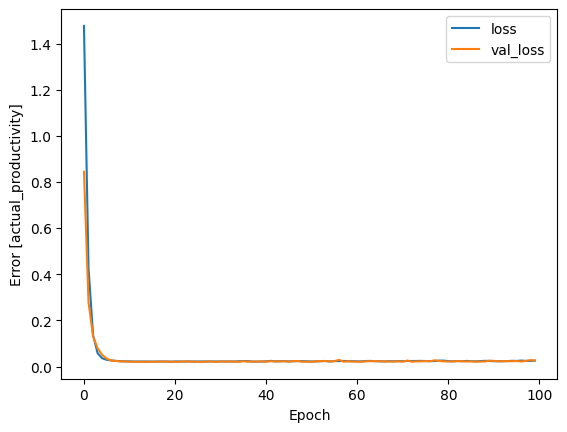

In [788]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

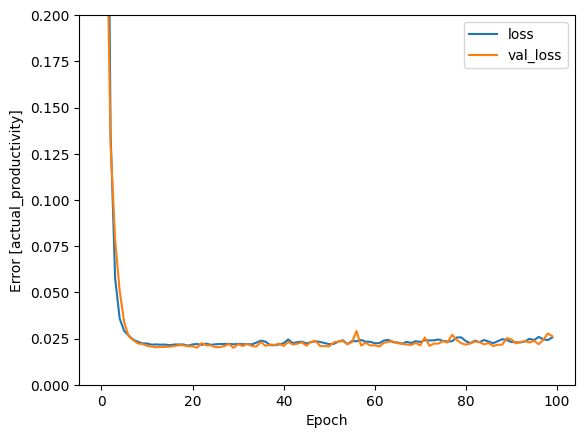

In [790]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0.0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

In [791]:
test_res = {}
test_res['linear_model'] = linear_model.evaluate(
    X_test,
    y_test, verbose=0)

In [792]:
test_res

{'linear_model': 0.02501094341278076}

## DNN

In [793]:
#Nueva libreria
import optuna

In [794]:
import optuna
import tensorflow as tf
from sklearn.metrics import r2_score

# Definir la función para construir el modelo
def build_model(trial, input_shape):
    # Definir hiperparámetros a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 6)  # Número de capas ocultas
    units_per_layer = [trial.suggest_int(f'units_{i}', 16, 250) for i in range(num_layers)]  # Unidades en cada capa
    activation_function = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])  # Función de activación
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje

    # Crear el modelo secuencial
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    # Añadir las capas ocultas
    for units in units_per_layer:
        model.add(tf.keras.layers.Dense(units, activation=activation_function))

    # Añadir la capa de salida
    model.add(tf.keras.layers.Dense(1))

    # Compilar el modelo
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate)
    )

    return model

# Definir la función para entrenar el modelo
def train_model(model, X_train, y_train):
    # Entrenar el modelo
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=100,
        verbose=0
    )
    return history

# Definir la función para evaluar el modelo
def evaluate_model(model, X_train, y_train):
    # Hacer predicciones en el conjunto de validación
    val_predictions = model.predict(X_train)

    # Calcular el R^2
    r2 = r2_score(y_train, val_predictions)

    return r2

# Definir la función objetivo para la optimización
def objective(trial):
    # Construir el modelo
    model = build_model(trial, input_shape=(X_train.shape[1],))

    # Entrenar el modelo
    train_model(model, X_train, y_train)

    # Evaluar el modelo
    r2 = evaluate_model(model, X_train, y_train)

    return r2

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2024-10-17 09:28:20,656] A new study created in memory with name: no-name-99a10d2d-3420-4004-a190-973d64784002
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:28:26,495] Trial 0 finished with value: -0.14188047563528627 and parameters: {'num_layers': 3, 'units_0': 209, 'units_1': 160, 'units_2': 127, 'activation': 'sigmoid', 'learning_rate': 0.0011894204114784794}. Best is trial 0 with value: -0.14188047563528627.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:28:30,889] Trial 1 finished with value: -0.003550082907373797 and parameters: {'num_layers': 2, 'units_0': 27, 'units_1': 86, 'activation': 'sigmoid', 'learning_rate': 0.007397375519317847}. Best is trial 1 with value: -0.003550082907373797.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:28:36,939] Trial 2 finished with value: -419.22217194431266 and parameters: {'num_layers': 3, 'units_0': 176, 'units_1': 153, 'units_2': 91, 'activation': 'relu', 'learning_rate': 2.3307965218120608e-05}. Best is trial 1 with value: -0.003550082907373797.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


[I 2024-10-17 09:28:41,459] Trial 3 finished with value: -0.03053994069595456 and parameters: {'num_layers': 2, 'units_0': 187, 'units_1': 205, 'activation': 'sigmoid', 'learning_rate': 1.0719073507786916e-05}. Best is trial 1 with value: -0.003550082907373797.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


[I 2024-10-17 09:28:45,392] Trial 4 finished with value: 0.09466370775554556 and parameters: {'num_layers': 1, 'units_0': 212, 'activation': 'sigmoid', 'learning_rate': 0.0004411961912595008}. Best is trial 4 with value: 0.09466370775554556.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:28:50,823] Trial 5 finished with value: 0.1734274586453146 and parameters: {'num_layers': 5, 'units_0': 150, 'units_1': 155, 'units_2': 85, 'units_3': 65, 'units_4': 154, 'activation': 'tanh', 'learning_rate': 0.00019605246303098682}. Best is trial 5 with value: 0.1734274586453146.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:28:57,705] Trial 6 finished with value: -0.1352468840224823 and parameters: {'num_layers': 4, 'units_0': 156, 'units_1': 61, 'units_2': 214, 'units_3': 187, 'activation': 'tanh', 'learning_rate': 0.006264659811712679}. Best is trial 5 with value: 0.1734274586453146.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


[I 2024-10-17 09:29:01,429] Trial 7 finished with value: -0.08332798222483828 and parameters: {'num_layers': 1, 'units_0': 68, 'activation': 'sigmoid', 'learning_rate': 0.06594149870361565}. Best is trial 5 with value: 0.1734274586453146.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


[I 2024-10-17 09:29:05,492] Trial 8 finished with value: 0.05571605754909015 and parameters: {'num_layers': 1, 'units_0': 137, 'activation': 'relu', 'learning_rate': 0.01794131577335406}. Best is trial 5 with value: 0.1734274586453146.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


[I 2024-10-17 09:29:10,501] Trial 9 finished with value: -1751.85006220866 and parameters: {'num_layers': 1, 'units_0': 59, 'activation': 'relu', 'learning_rate': 4.41101652451875e-05}. Best is trial 5 with value: 0.1734274586453146.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:29:19,994] Trial 10 finished with value: 0.35773938273144834 and parameters: {'num_layers': 6, 'units_0': 244, 'units_1': 240, 'units_2': 16, 'units_3': 31, 'units_4': 159, 'units_5': 214, 'activation': 'tanh', 'learning_rate': 0.0001946236688110921}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:29:30,386] Trial 11 finished with value: -0.3086719288979842 and parameters: {'num_layers': 6, 'units_0': 247, 'units_1': 241, 'units_2': 28, 'units_3': 31, 'units_4': 161, 'units_5': 225, 'activation': 'tanh', 'learning_rate': 0.00018170030488596294}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:29:37,217] Trial 12 finished with value: 0.022936757738039937 and parameters: {'num_layers': 6, 'units_0': 117, 'units_1': 240, 'units_2': 23, 'units_3': 37, 'units_4': 157, 'units_5': 180, 'activation': 'tanh', 'learning_rate': 0.00012301355780353413}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:29:42,511] Trial 13 finished with value: -0.13733540914458464 and parameters: {'num_layers': 5, 'units_0': 249, 'units_1': 17, 'units_2': 76, 'units_3': 86, 'units_4': 75, 'activation': 'tanh', 'learning_rate': 0.0009094163553316755}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:29:49,432] Trial 14 finished with value: -0.14141066403978075 and parameters: {'num_layers': 5, 'units_0': 103, 'units_1': 191, 'units_2': 196, 'units_3': 111, 'units_4': 245, 'activation': 'tanh', 'learning_rate': 0.00011359510937097224}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:29:54,336] Trial 15 finished with value: -0.6534203240963139 and parameters: {'num_layers': 5, 'units_0': 90, 'units_1': 111, 'units_2': 76, 'units_3': 21, 'units_4': 166, 'activation': 'tanh', 'learning_rate': 0.0018126044472777172}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:30:01,066] Trial 16 finished with value: 0.2904512684523849 and parameters: {'num_layers': 6, 'units_0': 219, 'units_1': 194, 'units_2': 166, 'units_3': 88, 'units_4': 92, 'units_5': 27, 'activation': 'tanh', 'learning_rate': 0.00025412523603800507}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:30:10,013] Trial 17 finished with value: 0.18018319233757984 and parameters: {'num_layers': 6, 'units_0': 219, 'units_1': 207, 'units_2': 172, 'units_3': 160, 'units_4': 68, 'units_5': 26, 'activation': 'tanh', 'learning_rate': 4.7371660033114465e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:30:17,740] Trial 18 finished with value: -0.18087450146611328 and parameters: {'num_layers': 4, 'units_0': 225, 'units_1': 190, 'units_2': 249, 'units_3': 116, 'activation': 'tanh', 'learning_rate': 0.0004475033195632146}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:30:25,949] Trial 19 finished with value: -0.20025526823388118 and parameters: {'num_layers': 6, 'units_0': 180, 'units_1': 249, 'units_2': 147, 'units_3': 246, 'units_4': 17, 'units_5': 72, 'activation': 'tanh', 'learning_rate': 0.0003531451538321547}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:30:33,168] Trial 20 finished with value: -0.05365090344117718 and parameters: {'num_layers': 4, 'units_0': 232, 'units_1': 225, 'units_2': 141, 'units_3': 75, 'activation': 'relu', 'learning_rate': 0.0027457338750675572}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:30:40,127] Trial 21 finished with value: 0.1852631705345794 and parameters: {'num_layers': 6, 'units_0': 201, 'units_1': 206, 'units_2': 182, 'units_3': 164, 'units_4': 84, 'units_5': 23, 'activation': 'tanh', 'learning_rate': 5.321878371968286e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:30:48,811] Trial 22 finished with value: 0.15517422610485576 and parameters: {'num_layers': 6, 'units_0': 199, 'units_1': 177, 'units_2': 187, 'units_3': 163, 'units_4': 95, 'units_5': 20, 'activation': 'tanh', 'learning_rate': 5.0820636516210695e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:30:56,895] Trial 23 finished with value: 0.028739755787787535 and parameters: {'num_layers': 5, 'units_0': 233, 'units_1': 214, 'units_2': 162, 'units_3': 212, 'units_4': 112, 'activation': 'tanh', 'learning_rate': 1.076926980438334e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:31:04,119] Trial 24 finished with value: 0.07558544658283439 and parameters: {'num_layers': 6, 'units_0': 164, 'units_1': 129, 'units_2': 221, 'units_3': 131, 'units_4': 208, 'units_5': 109, 'activation': 'tanh', 'learning_rate': 7.603838223234314e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:31:10,475] Trial 25 finished with value: -0.09360046008627831 and parameters: {'num_layers': 5, 'units_0': 196, 'units_1': 228, 'units_2': 117, 'units_3': 60, 'units_4': 36, 'activation': 'tanh', 'learning_rate': 2.5540216253517297e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:31:19,053] Trial 26 finished with value: 0.1823750060217576 and parameters: {'num_layers': 6, 'units_0': 240, 'units_1': 190, 'units_2': 107, 'units_3': 93, 'units_4': 113, 'units_5': 249, 'activation': 'tanh', 'learning_rate': 0.00021366438395500805}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:31:33,282] Trial 27 finished with value: -0.1421032434777707 and parameters: {'num_layers': 5, 'units_0': 210, 'units_1': 172, 'units_2': 174, 'units_3': 152, 'units_4': 58, 'activation': 'tanh', 'learning_rate': 0.0004955840465684109}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2024-10-17 09:31:40,759] Trial 28 finished with value: -9.295959295367892 and parameters: {'num_layers': 6, 'units_0': 173, 'units_1': 216, 'units_2': 52, 'units_3': 44, 'units_4': 131, 'units_5': 69, 'activation': 'relu', 'learning_rate': 2.3556715745333217e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:31:50,609] Trial 29 finished with value: -0.12471022530730314 and parameters: {'num_layers': 4, 'units_0': 200, 'units_1': 250, 'units_2': 155, 'units_3': 204, 'activation': 'tanh', 'learning_rate': 0.000822171113516739}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:31:56,884] Trial 30 finished with value: 0.08184872030879953 and parameters: {'num_layers': 3, 'units_0': 226, 'units_1': 133, 'units_2': 209, 'activation': 'sigmoid', 'learning_rate': 8.60964068126687e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:32:04,811] Trial 31 finished with value: -0.420555037539623 and parameters: {'num_layers': 6, 'units_0': 241, 'units_1': 193, 'units_2': 108, 'units_3': 105, 'units_4': 103, 'units_5': 244, 'activation': 'tanh', 'learning_rate': 0.0002236932755160889}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:32:11,398] Trial 32 finished with value: 0.12553125103898877 and parameters: {'num_layers': 6, 'units_0': 250, 'units_1': 227, 'units_2': 45, 'units_3': 92, 'units_4': 126, 'units_5': 195, 'activation': 'tanh', 'learning_rate': 0.00016358745564971891}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:32:18,579] Trial 33 finished with value: 0.1886278082312337 and parameters: {'num_layers': 6, 'units_0': 215, 'units_1': 185, 'units_2': 189, 'units_3': 138, 'units_4': 85, 'units_5': 249, 'activation': 'tanh', 'learning_rate': 0.0002999173589363405}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:32:24,598] Trial 34 finished with value: 0.0017607820514697892 and parameters: {'num_layers': 5, 'units_0': 188, 'units_1': 168, 'units_2': 237, 'units_3': 136, 'units_4': 84, 'activation': 'tanh', 'learning_rate': 0.0017960356856867477}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:32:29,292] Trial 35 finished with value: -0.15947096931095084 and parameters: {'num_layers': 2, 'units_0': 213, 'units_1': 204, 'activation': 'sigmoid', 'learning_rate': 0.0007471772956110006}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:32:35,408] Trial 36 finished with value: 0.002378370104006211 and parameters: {'num_layers': 6, 'units_0': 204, 'units_1': 144, 'units_2': 192, 'units_3': 179, 'units_4': 53, 'units_5': 158, 'activation': 'tanh', 'learning_rate': 0.0002655418319947083}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:32:41,583] Trial 37 finished with value: -0.03236233181113923 and parameters: {'num_layers': 5, 'units_0': 220, 'units_1': 183, 'units_2': 137, 'units_3': 133, 'units_4': 89, 'activation': 'sigmoid', 'learning_rate': 7.47882721548416e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:32:48,404] Trial 38 finished with value: 0.032229293754481136 and parameters: {'num_layers': 6, 'units_0': 185, 'units_1': 222, 'units_2': 169, 'units_3': 55, 'units_4': 195, 'units_5': 56, 'activation': 'tanh', 'learning_rate': 3.347361811317345e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:32:55,609] Trial 39 finished with value: -63.3044254265256 and parameters: {'num_layers': 5, 'units_0': 20, 'units_1': 159, 'units_2': 186, 'units_3': 141, 'units_4': 139, 'activation': 'relu', 'learning_rate': 1.4500859776536994e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:33:03,612] Trial 40 finished with value: -0.10105515018831546 and parameters: {'num_layers': 6, 'units_0': 152, 'units_1': 206, 'units_2': 126, 'units_3': 176, 'units_4': 182, 'units_5': 210, 'activation': 'tanh', 'learning_rate': 0.004036939679931285}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:33:11,508] Trial 41 finished with value: 0.06606877714129722 and parameters: {'num_layers': 6, 'units_0': 238, 'units_1': 196, 'units_2': 102, 'units_3': 79, 'units_4': 111, 'units_5': 236, 'activation': 'tanh', 'learning_rate': 0.0002877640403511688}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:33:18,387] Trial 42 finished with value: -0.11007143319191504 and parameters: {'num_layers': 6, 'units_0': 231, 'units_1': 182, 'units_2': 203, 'units_3': 99, 'units_4': 119, 'units_5': 243, 'activation': 'tanh', 'learning_rate': 0.0005729031406081401}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:33:29,873] Trial 43 finished with value: -0.07339719720790105 and parameters: {'num_layers': 6, 'units_0': 214, 'units_1': 236, 'units_2': 225, 'units_3': 117, 'units_4': 93, 'units_5': 247, 'activation': 'tanh', 'learning_rate': 0.00013649536482061769}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:33:37,165] Trial 44 finished with value: 0.024892192490705067 and parameters: {'num_layers': 5, 'units_0': 239, 'units_1': 147, 'units_2': 180, 'units_3': 69, 'units_4': 138, 'activation': 'tanh', 'learning_rate': 0.00030690475878535013}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:33:43,910] Trial 45 finished with value: -0.23557007944416553 and parameters: {'num_layers': 6, 'units_0': 168, 'units_1': 168, 'units_2': 57, 'units_3': 16, 'units_4': 74, 'units_5': 107, 'activation': 'tanh', 'learning_rate': 0.0013862137712020266}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:33:49,527] Trial 46 finished with value: -0.0229374829234672 and parameters: {'num_layers': 6, 'units_0': 134, 'units_1': 101, 'units_2': 153, 'units_3': 48, 'units_4': 49, 'units_5': 47, 'activation': 'sigmoid', 'learning_rate': 8.898995520457608e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


[I 2024-10-17 09:33:54,071] Trial 47 finished with value: -0.06039119986968089 and parameters: {'num_layers': 2, 'units_0': 191, 'units_1': 59, 'activation': 'relu', 'learning_rate': 0.025606047006814767}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:34:02,823] Trial 48 finished with value: 0.14612438709998687 and parameters: {'num_layers': 5, 'units_0': 207, 'units_1': 235, 'units_2': 34, 'units_3': 149, 'units_4': 145, 'activation': 'tanh', 'learning_rate': 0.00020550999938903896}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:34:08,897] Trial 49 finished with value: 0.1941269112714613 and parameters: {'num_layers': 4, 'units_0': 223, 'units_1': 213, 'units_2': 86, 'units_3': 120, 'activation': 'tanh', 'learning_rate': 6.35861748189088e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:34:15,140] Trial 50 finished with value: 0.19244735396569768 and parameters: {'num_layers': 3, 'units_0': 220, 'units_1': 206, 'units_2': 16, 'activation': 'tanh', 'learning_rate': 5.0696028540079185e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:34:22,530] Trial 51 finished with value: 0.14198042477896555 and parameters: {'num_layers': 3, 'units_0': 223, 'units_1': 215, 'units_2': 16, 'activation': 'tanh', 'learning_rate': 5.6194943193431395e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:34:28,182] Trial 52 finished with value: 0.16293092563645017 and parameters: {'num_layers': 3, 'units_0': 219, 'units_1': 204, 'units_2': 66, 'activation': 'tanh', 'learning_rate': 3.690230237127262e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:34:34,339] Trial 53 finished with value: 0.25605933574849593 and parameters: {'num_layers': 4, 'units_0': 209, 'units_1': 240, 'units_2': 37, 'units_3': 32, 'activation': 'tanh', 'learning_rate': 0.0001091953616850941}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:34:40,206] Trial 54 finished with value: 0.0167407096485358 and parameters: {'num_layers': 4, 'units_0': 39, 'units_1': 234, 'units_2': 35, 'units_3': 37, 'activation': 'tanh', 'learning_rate': 0.00038895496831540497}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:34:46,563] Trial 55 finished with value: 0.3071275133253807 and parameters: {'num_layers': 4, 'units_0': 232, 'units_1': 245, 'units_2': 17, 'units_3': 26, 'activation': 'tanh', 'learning_rate': 0.00011832309958436622}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:34:53,031] Trial 56 finished with value: 0.31857273775180683 and parameters: {'num_layers': 4, 'units_0': 250, 'units_1': 243, 'units_2': 21, 'units_3': 30, 'activation': 'tanh', 'learning_rate': 0.00011145326167067617}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:34:59,854] Trial 57 finished with value: 0.3322824994794572 and parameters: {'num_layers': 4, 'units_0': 250, 'units_1': 244, 'units_2': 29, 'units_3': 25, 'activation': 'tanh', 'learning_rate': 0.00010792544395997025}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-10-17 09:35:20,662] Trial 58 finished with value: 0.1830064994818964 and parameters: {'num_layers': 4, 'units_0': 248, 'units_1': 243, 'units_2': 29, 'units_3': 28, 'activation': 'tanh', 'learning_rate': 0.0001107693761677966}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:35:32,441] Trial 59 finished with value: -3130.590762989024 and parameters: {'num_layers': 4, 'units_0': 233, 'units_1': 250, 'units_2': 38, 'units_3': 27, 'activation': 'relu', 'learning_rate': 0.0001530346675272544}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-10-17 09:35:41,720] Trial 60 finished with value: 0.004335184155852212 and parameters: {'num_layers': 4, 'units_0': 240, 'units_1': 241, 'units_2': 26, 'units_3': 37, 'activation': 'tanh', 'learning_rate': 0.00010320250322155299}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:35:49,364] Trial 61 finished with value: 0.05496928253805744 and parameters: {'num_layers': 4, 'units_0': 250, 'units_1': 222, 'units_2': 45, 'units_3': 18, 'activation': 'tanh', 'learning_rate': 0.00012912641200470715}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:35:56,256] Trial 62 finished with value: 0.01666166078703124 and parameters: {'num_layers': 4, 'units_0': 229, 'units_1': 232, 'units_2': 84, 'units_3': 45, 'activation': 'tanh', 'learning_rate': 6.325531957671888e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:36:03,798] Trial 63 finished with value: -0.028672566277687883 and parameters: {'num_layers': 4, 'units_0': 240, 'units_1': 243, 'units_2': 67, 'units_3': 33, 'activation': 'tanh', 'learning_rate': 2.9270166376698174e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:36:10,250] Trial 64 finished with value: 0.15768178635919317 and parameters: {'num_layers': 4, 'units_0': 228, 'units_1': 215, 'units_2': 23, 'units_3': 54, 'activation': 'tanh', 'learning_rate': 1.8021597895731025e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:36:15,633] Trial 65 finished with value: -0.025704062016195905 and parameters: {'num_layers': 3, 'units_0': 244, 'units_1': 225, 'units_2': 45, 'activation': 'tanh', 'learning_rate': 0.00015831668949062443}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:36:22,577] Trial 66 finished with value: -0.04648365572482627 and parameters: {'num_layers': 4, 'units_0': 116, 'units_1': 241, 'units_2': 57, 'units_3': 69, 'activation': 'sigmoid', 'learning_rate': 6.809727507942224e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:36:30,793] Trial 67 finished with value: 0.17882467177893113 and parameters: {'num_layers': 4, 'units_0': 234, 'units_1': 245, 'units_2': 17, 'units_3': 26, 'activation': 'tanh', 'learning_rate': 9.841059269302839e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-10-17 09:36:38,442] Trial 68 finished with value: -0.015198898443846698 and parameters: {'num_layers': 3, 'units_0': 208, 'units_1': 229, 'units_2': 30, 'activation': 'tanh', 'learning_rate': 0.0006612778590756582}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:36:44,256] Trial 69 finished with value: -0.0601963266306762 and parameters: {'num_layers': 4, 'units_0': 77, 'units_1': 220, 'units_2': 40, 'units_3': 47, 'activation': 'tanh', 'learning_rate': 4.200733274308112e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:36:51,486] Trial 70 finished with value: 0.04558445776091469 and parameters: {'num_layers': 5, 'units_0': 144, 'units_1': 250, 'units_2': 69, 'units_3': 23, 'units_4': 244, 'activation': 'tanh', 'learning_rate': 0.00021627891712589425}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:36:58,743] Trial 71 finished with value: 0.13023485991618222 and parameters: {'num_layers': 3, 'units_0': 194, 'units_1': 200, 'units_2': 18, 'activation': 'tanh', 'learning_rate': 4.9674111100360566e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:37:04,334] Trial 72 finished with value: -0.01919095265297921 and parameters: {'num_layers': 2, 'units_0': 225, 'units_1': 210, 'activation': 'tanh', 'learning_rate': 8.69376246808086e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:37:14,739] Trial 73 finished with value: 0.09818081146288371 and parameters: {'num_layers': 3, 'units_0': 220, 'units_1': 237, 'units_2': 24, 'activation': 'tanh', 'learning_rate': 6.640132016027605e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:37:21,929] Trial 74 finished with value: 0.05380906530872864 and parameters: {'num_layers': 3, 'units_0': 244, 'units_1': 227, 'units_2': 53, 'activation': 'tanh', 'learning_rate': 0.00018286019091445473}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:37:28,455] Trial 75 finished with value: 0.039747692933477574 and parameters: {'num_layers': 2, 'units_0': 235, 'units_1': 231, 'activation': 'tanh', 'learning_rate': 1.8990393798659656e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:37:34,920] Trial 76 finished with value: -0.02503787904161947 and parameters: {'num_layers': 4, 'units_0': 213, 'units_1': 218, 'units_2': 22, 'units_3': 60, 'activation': 'tanh', 'learning_rate': 0.00011117234052920385}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:37:42,828] Trial 77 finished with value: -289.4262282682406 and parameters: {'num_layers': 3, 'units_0': 224, 'units_1': 21, 'units_2': 33, 'activation': 'relu', 'learning_rate': 0.00040343162319704415}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:37:49,314] Trial 78 finished with value: 0.18226916527067993 and parameters: {'num_layers': 4, 'units_0': 182, 'units_1': 212, 'units_2': 42, 'units_3': 34, 'activation': 'tanh', 'learning_rate': 4.417327402623792e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


[I 2024-10-17 09:37:53,897] Trial 79 finished with value: 0.1451499363288855 and parameters: {'num_layers': 1, 'units_0': 250, 'activation': 'sigmoid', 'learning_rate': 3.244905205039296e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:37:59,752] Trial 80 finished with value: 0.11916195300139854 and parameters: {'num_layers': 5, 'units_0': 201, 'units_1': 196, 'units_2': 17, 'units_3': 123, 'units_4': 221, 'activation': 'tanh', 'learning_rate': 0.00024856528029017097}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:38:05,130] Trial 81 finished with value: -0.019358612641663164 and parameters: {'num_layers': 4, 'units_0': 218, 'units_1': 177, 'units_2': 29, 'units_3': 41, 'activation': 'tanh', 'learning_rate': 0.0003237075612387425}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:38:11,551] Trial 82 finished with value: 0.19449218075379326 and parameters: {'num_layers': 5, 'units_0': 214, 'units_1': 238, 'units_2': 164, 'units_3': 80, 'units_4': 165, 'activation': 'tanh', 'learning_rate': 0.0001360895343658778}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:38:21,222] Trial 83 finished with value: 0.2821109761483289 and parameters: {'num_layers': 5, 'units_0': 230, 'units_1': 239, 'units_2': 124, 'units_3': 83, 'units_4': 170, 'activation': 'tanh', 'learning_rate': 0.00013401994560956662}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-10-17 09:38:28,751] Trial 84 finished with value: 0.14486539717393265 and parameters: {'num_layers': 5, 'units_0': 230, 'units_1': 238, 'units_2': 96, 'units_3': 80, 'units_4': 171, 'activation': 'tanh', 'learning_rate': 0.00012859712549994742}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:38:38,395] Trial 85 finished with value: 0.14743725233988392 and parameters: {'num_layers': 5, 'units_0': 243, 'units_1': 247, 'units_2': 126, 'units_3': 89, 'units_4': 177, 'activation': 'tanh', 'learning_rate': 0.00017435202964660894}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:38:46,868] Trial 86 finished with value: 0.22348399797007856 and parameters: {'num_layers': 5, 'units_0': 236, 'units_1': 233, 'units_2': 164, 'units_3': 104, 'units_4': 190, 'activation': 'tanh', 'learning_rate': 7.831997183299864e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2024-10-17 09:38:56,696] Trial 87 finished with value: 0.09983184427996172 and parameters: {'num_layers': 5, 'units_0': 235, 'units_1': 231, 'units_2': 156, 'units_3': 108, 'units_4': 154, 'activation': 'tanh', 'learning_rate': 0.00013250779595566116}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-10-17 09:39:04,759] Trial 88 finished with value: -0.05409341609312013 and parameters: {'num_layers': 5, 'units_0': 204, 'units_1': 237, 'units_2': 167, 'units_3': 82, 'units_4': 156, 'activation': 'tanh', 'learning_rate': 0.00023642988348673323}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:39:12,857] Trial 89 finished with value: -0.015525525436370424 and parameters: {'num_layers': 5, 'units_0': 244, 'units_1': 245, 'units_2': 160, 'units_3': 98, 'units_4': 185, 'activation': 'tanh', 'learning_rate': 8.349895449661694e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:39:23,734] Trial 90 finished with value: -1.4505330135005274 and parameters: {'num_layers': 5, 'units_0': 237, 'units_1': 224, 'units_2': 145, 'units_3': 74, 'units_4': 198, 'activation': 'relu', 'learning_rate': 0.0004976114988327349}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:39:31,247] Trial 91 finished with value: 0.16445680076072788 and parameters: {'num_layers': 4, 'units_0': 227, 'units_1': 240, 'units_2': 175, 'units_3': 126, 'activation': 'tanh', 'learning_rate': 7.361290826219898e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:39:39,012] Trial 92 finished with value: 0.1590530367079005 and parameters: {'num_layers': 4, 'units_0': 209, 'units_1': 230, 'units_2': 117, 'units_3': 114, 'activation': 'tanh', 'learning_rate': 0.00010318375503988376}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:39:46,542] Trial 93 finished with value: 0.017118837654131247 and parameters: {'num_layers': 4, 'units_0': 215, 'units_1': 221, 'units_2': 148, 'units_3': 101, 'activation': 'tanh', 'learning_rate': 0.00014485876475861818}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:39:54,900] Trial 94 finished with value: 0.01694364972774265 and parameters: {'num_layers': 5, 'units_0': 245, 'units_1': 246, 'units_2': 135, 'units_3': 86, 'units_4': 165, 'activation': 'tanh', 'learning_rate': 0.00018769610300213856}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:40:01,034] Trial 95 finished with value: 0.1798653528875398 and parameters: {'num_layers': 4, 'units_0': 229, 'units_1': 234, 'units_2': 179, 'units_3': 16, 'activation': 'tanh', 'learning_rate': 6.0050548112997165e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:40:09,365] Trial 96 finished with value: 0.26507655704945865 and parameters: {'num_layers': 6, 'units_0': 237, 'units_1': 239, 'units_2': 114, 'units_3': 53, 'units_4': 229, 'units_5': 142, 'activation': 'tanh', 'learning_rate': 8.329818232559807e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:40:16,601] Trial 97 finished with value: -0.3509959413392927 and parameters: {'num_layers': 6, 'units_0': 237, 'units_1': 249, 'units_2': 118, 'units_3': 54, 'units_4': 224, 'units_5': 138, 'activation': 'tanh', 'learning_rate': 8.85422602549724e-05}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:40:35,671] Trial 98 finished with value: -0.00043223404468539783 and parameters: {'num_layers': 6, 'units_0': 246, 'units_1': 241, 'units_2': 200, 'units_3': 61, 'units_4': 226, 'units_5': 165, 'activation': 'sigmoid', 'learning_rate': 0.08340478790250538}. Best is trial 10 with value: 0.35773938273144834.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1056589384.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:40:44,326] Trial 99 finished with value: 0.07087913772253251 and parameters: {'num_layers': 6, 'units_0': 231, 'units_1': 227, 'units_2': 132, 'units_3': 23, 'units_4': 205, 'units_5': 94, 'activation': 'tanh', 'learning_rate': 0.00015406338491174773}. Best is trial 10 with value: 0.35773938273144834.


In [795]:
# Supongamos que estos son los mejores hiperparámetros y el mejor R^2 obtenidos del estudio
best_params = study.best_params
best_r2 = study.best_value

# Imprimir los mejores hiperparámetros de manera legible
print("Mejores hiperparámetros:")
print(f"  - Número de capas ocultas: {best_params['num_layers']}")
for i in range(best_params['num_layers']):
    print(f"  - Unidades en la capa {i}: {best_params[f'units_{i}']}")
    print(f"  - Función de activación: {best_params['activation']}")
print(f"  - Tasa de aprendizaje: {best_params['learning_rate']:.8f}")
print(f"Mejor R^2: {best_r2:.6f}")
print(best_params)

Mejores hiperparámetros:
  - Número de capas ocultas: 6
  - Unidades en la capa 0: 244
  - Función de activación: tanh
  - Unidades en la capa 1: 240
  - Función de activación: tanh
  - Unidades en la capa 2: 16
  - Función de activación: tanh
  - Unidades en la capa 3: 31
  - Función de activación: tanh
  - Unidades en la capa 4: 159
  - Función de activación: tanh
  - Unidades en la capa 5: 214
  - Función de activación: tanh
  - Tasa de aprendizaje: 0.00019462
Mejor R^2: 0.357739
{'num_layers': 6, 'units_0': 244, 'units_1': 240, 'units_2': 16, 'units_3': 31, 'units_4': 159, 'units_5': 214, 'activation': 'tanh', 'learning_rate': 0.0001946236688110921}


## Empleando los mejores hiperparámetros

Modelo con multiples varaibles de entrada

In [831]:
dnn_model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(41, activation='sigmoid'),
      tf.keras.layers.Dense(128, activation='sigmoid'),
      tf.keras.layers.Dense(1)
  ])

In [832]:
dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(best_params['learning_rate']))


In [833]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3489 - val_loss: 0.1407
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1525 - val_loss: 0.1314
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1359 - val_loss: 0.1316
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1267 - val_loss: 0.1290
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1266 - val_loss: 0.1282
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1190 - val_loss: 0.1238
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1213 - val_loss: 0.1228
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1185 - val_loss: 0.1198
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1206 - val_loss: 0.1194
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1139 - val_loss: 0.1167
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1103 - val_loss: 0.1180
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1

In [834]:
dnn_model.summary()

Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 30)             │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_580 (Dense)               │ (None, 41)             │         1,271 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_581 (Dense)               │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_582 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,391 (79.66 KB)

 Trainable params: 6,776 (26.47 KB)

 Non-trainable params: 61 (248.00 B)

 Optimizer params: 13,554 (52.95 KB)

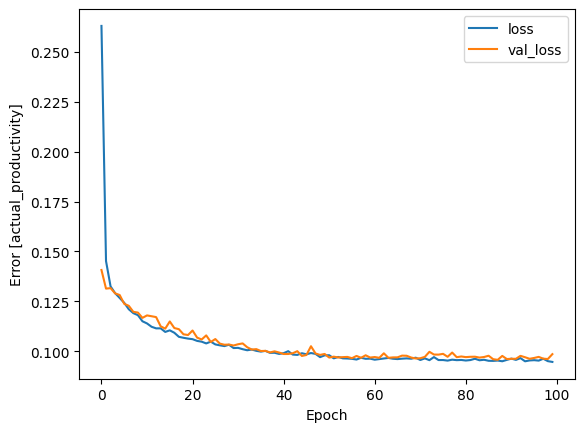

In [835]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

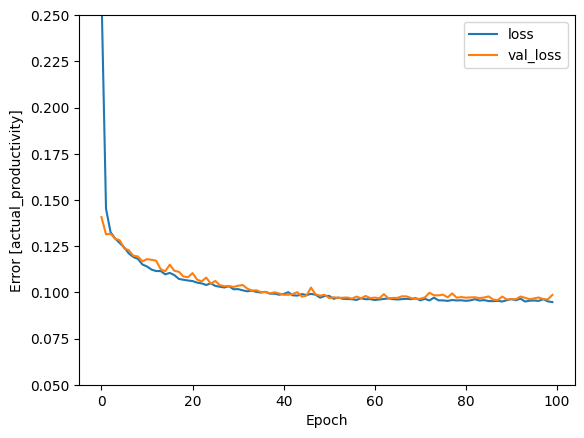

In [837]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0.05, 0.25])
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

In [827]:
test_res['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)

In [808]:
test_res

{'linear_model': 0.02501094341278076, 'dnn_model': 0.09237290173768997}

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


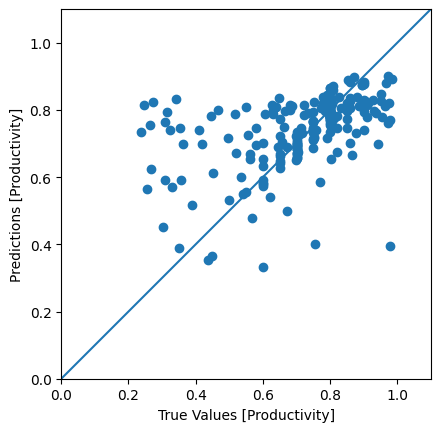

In [809]:
test_pred = dnn_model.predict(X_test).flatten()

plt.axes(aspect='equal')
plt.scatter(y_test, test_pred)
plt.xlabel('True Values [Productivity]')
plt.ylabel('Predictions [Productivity]')
lims = [0, 1.1]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)

## Evaluacion de los modelos

In [810]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [811]:
#Prediccion del modelo lineal
linear_model_pred = linear_model.predict(X_test).flatten()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [812]:
# Calcular métricas para el modelo lineal
mae_ml = mean_absolute_error(y_test, linear_model_pred)
mse_ml = mean_squared_error(y_test, linear_model_pred)
rmse_ml = np.sqrt(mse_ml)
r2_ml = r2_score(y_test, linear_model_pred)


In [813]:
#Evaluacion del modelo DNN
dnn_model_pred= dnn_model.predict(X_test).flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


In [814]:
# Calcular métricas para el modelo DNN
mae_dnn = mean_absolute_error(y_test, dnn_model_pred)
mse_dnn = mean_squared_error(y_test, dnn_model_pred)
rmse_dnn = np.sqrt(mse_dnn)
r2_dnn = r2_score(y_test, dnn_model_pred)

In [815]:
# Create a DataFrame to compare the metrics of the models
metrics_comparison = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R^2 Score'],
    'Linear Model': [mae_ml, mse_ml, rmse_ml, r2_ml],
    'DNN Model': [mae_dnn, mse_dnn, rmse_dnn, r2_dnn]
})

# Print the DataFrame
print(metrics_comparison)

                           Metric  Linear Model  DNN Model
0       Mean Absolute Error (MAE)      0.115148   0.092851
1        Mean Squared Error (MSE)      0.025011   0.022128
2  Root Mean Squared Error (RMSE)      0.158148   0.148754
3                       R^2 Score      0.117408   0.219151
